<a href="https://colab.research.google.com/github/ougrid/my-knowledge-resource/blob/master/Few_shot_hands_on2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown 1JEwDqWHwRfvzvd2O1EbYR6li0VlRf7aF

Downloading...
From: https://drive.google.com/uc?id=1JEwDqWHwRfvzvd2O1EbYR6li0VlRf7aF
To: /content/archive.zip
100% 3.78M/3.78M [00:00<00:00, 232MB/s]


In [ ]:
!unzip /content/archive.zip -d /content/data
!rm /content/data/README

Archive:  /content/archive.zip
  inflating: /content/data/README    
replace /content/data/s1/1.pgm? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/data/s1/1.pgm  
  inflating: /content/data/s1/10.pgm  
  inflating: /content/data/s1/2.pgm  
  inflating: /content/data/s1/3.pgm  
  inflating: /content/data/s1/4.pgm  
  inflating: /content/data/s1/5.pgm  
  inflating: /content/data/s1/6.pgm  
  inflating: /content/data/s1/7.pgm  
  inflating: /content/data/s1/8.pgm  
  inflating: /content/data/s1/9.pgm  
  inflating: /content/data/s10/1.pgm  
  inflating: /content/data/s10/10.pgm  
  inflating: /content/data/s10/2.pgm  
  inflating: /content/data/s10/3.pgm  
  inflating: /content/data/s10/4.pgm  
  inflating: /content/data/s10/5.pgm  
  inflating: /content/data/s10/6.pgm  
  inflating: /content/data/s10/7.pgm  
  inflating: /content/data/s10/8.pgm  
  inflating: /content/data/s10/9.pgm  
  inflating: /content/data/s11/1.pgm  
  inflating: /content/data/s11/10.pgm  
  inflat

In [ ]:
# prompt: delete /content/data/README




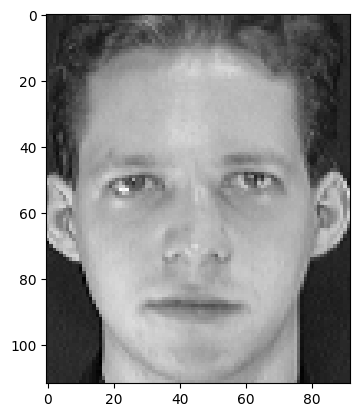

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/content/data/s1/1.pgm')
imgplot = plt.imshow(img, cmap='gray')
plt.show()

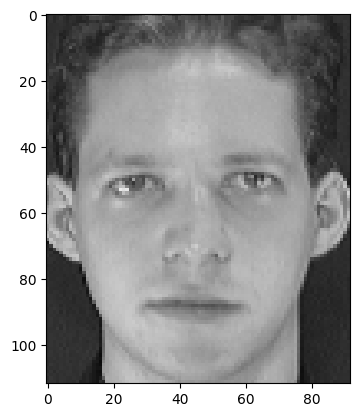

In [ ]:
import numpy as np
img_rgb = np.stack((img,)*3, axis=-1)

imgplot = plt.imshow(img_rgb)
plt.show()

In [ ]:
import pandas as pd
import os

df = pd.DataFrame(columns=['filename', 'class'])
for folder in os.listdir('/content/data'):
  for filename in os.listdir('/content/data/' + folder):
    df=pd.concat([df, pd.DataFrame({'filename': [folder+"/"+filename], 'class': [folder]})], ignore_index=True)

print(df.head())

    filename class
0  s10/5.pgm   s10
1  s10/2.pgm   s10
2  s10/6.pgm   s10
3  s10/4.pgm   s10
4  s10/8.pgm   s10


In [ ]:
# prompt: divide df into train-validate-test by the retio 70:10:20 for each class

import pandas as pd
from sklearn.model_selection import train_test_split

train_df = pd.DataFrame()
val_df = pd.DataFrame()
test_df = pd.DataFrame()

for c in df['class'].unique():
  df_class = df[df['class'] == c]
  df_class_train, df_class_test = train_test_split(df_class, test_size=0.2, random_state=42)
  df_class_train, df_class_val = train_test_split(df_class_train, test_size=0.2, random_state=42)
  train_df = pd.concat([train_df, df_class_train])
  val_df = pd.concat([val_df, df_class_val])
  test_df = pd.concat([test_df, df_class_test])

print(train_df.shape, val_df.shape, test_df.shape)


(240, 2) (80, 2) (80, 2)


In [ ]:
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [ ]:
# prompt: create dataset using pytorch

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
  def __init__(self, df, root_dir, transform=None):
    self.df = df
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def get_p(self,idx, label):
    p_df=self.df.drop(idx)
    p_df=p_df[p_df['class']==label]
    idx=np.random.randint(0, len(p_df))
    img_path = os.path.join(self.root_dir, p_df.iloc[idx, 0])
    image = Image.open(img_path).convert('RGB')
    if self.transform:
      image = self.transform(image)
    return image

  def get_n(self,label):
    n_df=self.df[self.df['class']!=label]
    idx=np.random.randint(0, len(n_df))
    img_path = os.path.join(self.root_dir, n_df.iloc[idx, 0])
    image = Image.open(img_path).convert('RGB')
    label = self.df.iloc[idx, 1]
    if self.transform:
      image = self.transform(image)
    return image, label

  def __getitem__(self, idx):
    img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
    image = Image.open(img_path).convert('RGB')
    label = self.df.iloc[idx, 1]
    if self.transform:
      image = self.transform(image)
    n_img,n_class=self.get_n(label)
    return image, label, self.get_p(idx,label), n_img,n_class

# Revise data_transform for ResNet

train_test_split_transform = transforms.Compose([
    # transforms.Resize(256),  # Resize to a slightly larger size
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    # transforms.CenterCrop(224),  # Center crop to 224x224
    transforms.Resize((224,224)),  # Resize to a slightly larger size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for ImageNet
])

test_transform = transforms.Compose([
    # transforms.Resize(256),  # Resize to a slightly larger size
    # transforms.CenterCrop(224),  # Center crop to 224x224
    transforms.Resize((224,224)),  # Resize to a slightly larger size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for ImageNet
])

train_dataset = CustomDataset(train_df, '/content/data', transform=train_test_split_transform)
val_dataset = CustomDataset(val_df, '/content/data', transform=train_test_split_transform)
test_dataset = CustomDataset(test_df, '/content/data', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


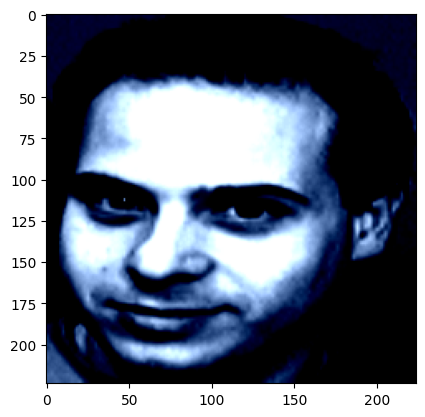

In [ ]:
# prompt: read image from train_loader and show

import matplotlib.pyplot as plt
# Get a batch of images and labels
images, labels,p_img,n_img, n_class = next(iter(train_loader))

# Display the first image in the batch
img = images[0].permute(1, 2, 0).numpy()  # Permute dimensions and convert to NumPy array
plt.imshow(img)
plt.show()

In [ ]:
# prompt: load restnet model using pretrained weight and revise the data_transform accordingly

import torchvision.models as models

# Load pretrained ResNet model (ResNet18 in this case)
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer to match the number of classes in your dataset
num_classes = len(df['class'].unique())  # Assuming df is your DataFrame with class labels
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, num_ftrs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from torch import nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = torch.nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Early stopping parameters
patience = 10
best_val_loss = float('inf')
epochs_without_improvement = 0

num_epochs = 100  # Set the number of epochs

for epoch in range(num_epochs):
  # Training
  model.train()
  train_loss = 0.0
  for images, labels, p_img, n_img, _ in train_loader:
    images = images.to(device)
    p_img = p_img.to(device)
    n_img = n_img.to(device)

    optimizer.zero_grad()
    embeddings = model(images)
    positive_embeddings = model(p_img)
    negative_embeddings = model(n_img)
    loss = criterion(embeddings, positive_embeddings, negative_embeddings)
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * images.size(0)

  train_loss = train_loss / len(train_loader.dataset)

  # Validation
  model.eval()
  val_loss = 0.0
  with torch.no_grad():
    for images, labels, p_img, n_img, _ in val_loader:
      images = images.to(device)
      p_img = p_img.to(device)
      n_img = n_img.to(device)

      embeddings = model(images)
      positive_embeddings = model(p_img)
      negative_embeddings = model(n_img)
      loss = criterion(embeddings, positive_embeddings, negative_embeddings)
      val_loss += loss.item() * images.size(0)

  val_loss = val_loss / len(val_loader.dataset)

  print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, epochs without improvement:{epochs_without_improvement:.0f}')

  # Early stopping check
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    epochs_without_improvement = 0
    best_model=model.state_dict().copy()
  else:
    epochs_without_improvement += 1
    if epochs_without_improvement >= patience:
      print("Early stopping triggered!")
      break
model.load_state_dict(best_model)

Epoch 1/100, Train Loss: 0.0146, Val Loss: 0.0946, epochs without improvement:0
Epoch 2/100, Train Loss: 0.0116, Val Loss: 0.0106, epochs without improvement:0
Epoch 3/100, Train Loss: 0.0133, Val Loss: 0.0747, epochs without improvement:0
Epoch 4/100, Train Loss: 0.0480, Val Loss: 0.0000, epochs without improvement:1
Epoch 5/100, Train Loss: 0.0500, Val Loss: 0.0136, epochs without improvement:0
Epoch 6/100, Train Loss: 0.0003, Val Loss: 0.0427, epochs without improvement:1
Epoch 7/100, Train Loss: 0.0071, Val Loss: 0.0000, epochs without improvement:2
Epoch 8/100, Train Loss: 0.0000, Val Loss: 0.0000, epochs without improvement:3
Epoch 9/100, Train Loss: 0.0243, Val Loss: 0.0159, epochs without improvement:4
Epoch 10/100, Train Loss: 0.0322, Val Loss: 0.0427, epochs without improvement:5
Epoch 11/100, Train Loss: 0.0063, Val Loss: 0.0529, epochs without improvement:6
Epoch 12/100, Train Loss: 0.0134, Val Loss: 0.0673, epochs without improvement:7
Epoch 13/100, Train Loss: 0.0165, Val

<All keys matched successfully>

In [ ]:
# prompt: evaluate the model

import numpy as np
def evaluate(model, test_loader, device):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for data, target, _, _, _ in test_loader:
            data = data.to(device)
            outputs = model(data)
            embeddings.append(outputs.cpu().numpy())
            labels.append(target)

    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)

    # Perform evaluation (e.g., calculate accuracy using k-nearest neighbors)
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(embeddings, labels)
    accuracy = knn.score(embeddings, labels)
    print(f"Accuracy: {accuracy:.4f}")

evaluate(model, test_loader, device)


Accuracy: 0.5750


In [ ]:
# prompt: fine-tune 20% of the pretrained model

# Freeze most layers and unfreeze the last 20%
total_params = sum(p.numel() for p in model.parameters())
num_params_to_finetune = int(total_params * 0.8)

params_finetuned = 0
for param in model.parameters():
    param.requires_grad = False  # Freeze all by default

for param in model.parameters():
    if params_finetuned > num_params_to_finetune:
        param.requires_grad = True
    params_finetuned += param.numel()

# Now only the last 20% of parameters are trainable


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0

num_epochs = 50  # Set the number of epochs

for epoch in range(num_epochs):
  # Training
  model.train()
  train_loss = 0.0
  for images, labels, p_img, n_img, _ in train_loader:
    images = images.to(device)
    p_img = p_img.to(device)
    n_img = n_img.to(device)

    optimizer.zero_grad()
    embeddings = model(images)
    positive_embeddings = model(p_img)
    negative_embeddings = model(n_img)
    loss = criterion(embeddings, positive_embeddings, negative_embeddings)
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * images.size(0)

  train_loss = train_loss / len(train_loader.dataset)

  # Validation
  model.eval()
  val_loss = 0.0
  with torch.no_grad():
    for images, labels, p_img, n_img, _ in val_loader:
      images = images.to(device)
      p_img = p_img.to(device)
      n_img = n_img.to(device)

      embeddings = model(images)
      positive_embeddings = model(p_img)
      negative_embeddings = model(n_img)
      loss = criterion(embeddings, positive_embeddings, negative_embeddings)
      val_loss += loss.item() * images.size(0)

  val_loss = val_loss / len(val_loader.dataset)

  print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, epochs without improvement:{epochs_without_improvement:.0f}')

  # Early stopping check
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    epochs_without_improvement = 0
    best_model=model.state_dict().copy()
  else:
    epochs_without_improvement += 1
    if epochs_without_improvement >= patience:
      print("Early stopping triggered!")
      break
model.load_state_dict(best_model)

Epoch 1/50, Train Loss: 0.0000, Val Loss: 0.0000, epochs without improvement:0
Epoch 2/50, Train Loss: 0.0473, Val Loss: 0.0170, epochs without improvement:0
Epoch 3/50, Train Loss: 0.0023, Val Loss: 0.1476, epochs without improvement:1
Epoch 4/50, Train Loss: 0.0102, Val Loss: 0.0001, epochs without improvement:2
Epoch 5/50, Train Loss: 0.0107, Val Loss: 0.0350, epochs without improvement:3
Epoch 6/50, Train Loss: 0.0349, Val Loss: 0.0303, epochs without improvement:4
Early stopping triggered!


<All keys matched successfully>

In [ ]:
# prompt: evaluate the model

import numpy as np
def evaluate(model, test_loader, device):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for data, target, _, _, _ in test_loader:
            data = data.to(device)
            outputs = model(data)
            embeddings.append(outputs.cpu().numpy())
            labels.append(target)

    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)

    # Perform evaluation (e.g., calculate accuracy using k-nearest neighbors)
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(embeddings, labels)
    accuracy = knn.score(embeddings, labels)
    print(f"Accuracy: {accuracy:.4f}")

evaluate(model, test_loader, device)


Accuracy: 0.5750
